In [3]:
import os
import numpy as np

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

In [4]:
def search_data(sequence_length, num_of_depend, label_start_idx,num_for_predict, units, points_per_hour):
    '''
    Parameters
    ----------
    sequence_length: int, length of all history data
    num_of_depend: int,
    label_start_idx: int, the first index of predicting target
    num_for_predict: int, the number of points will be predicted for each sample
    units: int, week: 7 * 24, day: 24, recent(hour): 1
    points_per_hour: int, number of points per hour, depends on data
    Returns
    ----------
    list[(start_idx, end_idx)]
    '''

    if points_per_hour < 0:
        raise ValueError("points_per_hour should be greater than 0!")

    if label_start_idx + num_for_predict > sequence_length:
        return None

    x_idx = []
    for i in range(1, num_of_depend + 1):
        start_idx = label_start_idx - points_per_hour * units * i
        end_idx = start_idx + num_for_predict
        if start_idx >= 0:
            x_idx.append((start_idx, end_idx))
        else:
            return None

    if len(x_idx) != num_of_depend:
        return None

    return x_idx[::-1]

In [5]:
def get_sample_indices(data_sequence, num_of_weeks, num_of_days, num_of_hours, label_start_idx, num_for_predict, points_per_hour=12):
    '''
    Parameters
    ----------
    data_sequence: np.ndarray shape is (sequence_length, num_of_vertices, num_of_features)
    num_of_weeks, num_of_days, num_of_hours: int
    label_start_idx: int, the first index of predicting target
    num_for_predict: int,the number of points will be predicted for each sample
    points_per_hour: int, default 12, number of points per hour
    Returns
    ----------
    week_sample: np.ndarray shape is (num_of_weeks * points_per_hour, num_of_vertices, num_of_features)
    day_sample: np.ndarray shape is (num_of_days * points_per_hour,  num_of_vertices, num_of_features)
    hour_sample: np.ndarray   shape is (num_of_hours * points_per_hour, num_of_vertices, num_of_features)
    target: np.ndarray shape is (num_for_predict, num_of_vertices, num_of_features)
    '''
    week_sample, day_sample, hour_sample = None, None, None
#------------------------------------Ignore
    if label_start_idx + num_for_predict > data_sequence.shape[0]: 
        return week_sample, day_sample, hour_sample, None

    if num_of_weeks > 0:
        week_indices = search_data(data_sequence.shape[0], num_of_weeks, label_start_idx, num_for_predict,7 * 24, points_per_hour)
        if not week_indices:
            return None, None, None, None

        week_sample = np.concatenate([data_sequence[i: j] for i, j in week_indices], axis=0)

    if num_of_days > 0:
        day_indices = search_data(data_sequence.shape[0], num_of_days,  label_start_idx, num_for_predict, 24, points_per_hour)
        if not day_indices:
            return None, None, None, None

        day_sample = np.concatenate([data_sequence[i: j] for i, j in day_indices], axis=0)
#----------------------------------Continue
    if num_of_hours > 0:
        hour_indices = search_data(data_sequence.shape[0], num_of_hours, label_start_idx, num_for_predict, 1, points_per_hour)
        if not hour_indices:
            return None, None, None, None
        hour_sample = np.concatenate([data_sequence[i: j] for i, j in hour_indices], axis=0)
    
    if num_of_hours > 10:
        return 1;
    target = data_sequence[label_start_idx: label_start_idx + num_for_predict]

    return week_sample, day_sample, hour_sample, target

In [6]:
def read_and_generate_dataset(graph_signal_matrix_filename, num_of_weeks, num_of_days, num_of_hours, num_for_predict, points_per_hour=12):
    '''
    Parameters
    ----------
    graph_signal_matrix_filename: str, path of graph signal matrix file
    num_of_weeks, num_of_days, num_of_hours: int
    num_for_predict: int
    points_per_hour: int, default 12, depends on data
    Returns
    ----------
    feature: np.ndarray, shape is (num_of_samples, num_of_depend * points_per_hour, num_of_vertices, num_of_features)
    target: np.ndarray, shape is (num_of_samples, num_of_vertices, num_for_predict)
    '''
    #--------------------------------- Read original data 
    data_seq = np.load(graph_signal_matrix_filename)['data']  # (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)
    
    #---------------------------------
    all_samples = []
    for idx in range(data_seq.shape[0]):
        sample = get_sample_indices(data_seq, num_of_weeks, num_of_days, num_of_hours, idx, num_for_predict, points_per_hour)
        if ((sample[0] is None) and (sample[1] is None) and (sample[2] is None)):
            continue

        week_sample, day_sample, hour_sample, target = sample #  week_sample, day_sample are None because we are predicting per hour
        #print(target.shape) # hour_sample and target (12, 307, 3)
        sample = []  # [(week_sample),(day_sample),(hour_sample),target,time_sample]
#-------------------------------- Ignore
        if num_of_weeks > 0:
            week_sample = np.expand_dims(week_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(week_sample)

        if num_of_days > 0:
            day_sample = np.expand_dims(day_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(day_sample)
#----------------------------------Continue
        if num_of_hours > 0:
            hour_sample = np.expand_dims(hour_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(hour_sample)

        target = np.expand_dims(target, axis=0).transpose((0, 2, 3, 1))[:, :, 0, :]  # (1,N,T)
        sample.append(target)
        time_sample = np.expand_dims(np.array([idx]), axis=0)  # (1,1)
        sample.append(time_sample)
        all_samples.append(sample)#sampe：[(week_sample),(day_sample),(hour_sample),target,time_sample] = [(1,N,F,Tw),(1,N,F,Td),(1,N,F,Th),(1,N,Tpre),(1,1)]

    split_line1 = int(len(all_samples) * 0.6)
    split_line2 = int(len(all_samples) * 0.8)

    training_set = [np.concatenate(i, axis=0)  for i in zip(*all_samples[:split_line1])] #[(B,N,F,Tw),(B,N,F,Td),(B,N,F,Th),(B,N,Tpre),(B,1)]
    validation_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line1: split_line2])]
    testing_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line2:])]

    return training_set, validation_set, testing_set

In [7]:
graph_signal_matrix_filename = 'PEMS04.npz'
data = np.load(graph_signal_matrix_filename)
data['data'].shape

(16992, 307, 3)

In [8]:
data = np.load(graph_signal_matrix_filename)
data['data'].shape

num_of_vertices = 307
points_per_hour = 12
num_for_predict = 12
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

training_set, validation_set, testing_set = read_and_generate_dataset(graph_signal_matrix_filename, 0, 0, num_of_hours, 
                                                                      num_for_predict, points_per_hour=points_per_hour)

In [9]:
def normalization(train, val, test):
    '''
    Parameters
    ----------
    train, val, test: np.ndarray (B,N,F,T)
    Returns
    ----------
    stats: dict, two keys: mean and std
    train_norm, val_norm, test_norm: np.ndarray,
                                     shape is the same as original
    '''

    assert train.shape[1:] == val.shape[1:] and val.shape[1:] == test.shape[1:]  # ensure the num of nodes is the same
    mean = train.mean(axis=(0,1,3), keepdims=True)
    std = train.std(axis=(0,1,3), keepdims=True)
    print('mean.shape:',mean.shape)
    print('std.shape:',std.shape)

    def normalize(x):
        return (x - mean) / std

    train_norm = normalize(train)
    val_norm = normalize(val)
    test_norm = normalize(test)

    return {'_mean': mean, '_std': std}, train_norm, val_norm, test_norm

In [10]:
train_x = np.concatenate(training_set[:-2], axis=-1)  # (B,N,F,T')
val_x = np.concatenate(validation_set[:-2], axis=-1)
test_x = np.concatenate(testing_set[:-2], axis=-1)

train_target = training_set[-2]  # (B,N,T)
val_target = validation_set[-2]
test_target = testing_set[-2]

train_timestamp = training_set[-1]  # (B,1)
val_timestamp = validation_set[-1]
test_timestamp = testing_set[-1]

(stats, train_x_norm, val_x_norm, test_x_norm) = normalization(train_x, val_x, test_x)

all_data = {'train': { 'x': train_x_norm, 'target': train_target,'timestamp': train_timestamp},
            'val': {'x': val_x_norm, 'target': val_target, 'timestamp': val_timestamp},
            'test': {'x': test_x_norm, 'target': test_target, 'timestamp': test_timestamp},
            'stats': {'_mean': stats['_mean'], '_std': stats['_std']} }

mean.shape: (1, 1, 3, 1)
std.shape: (1, 1, 3, 1)


In [20]:
print('train x:', all_data['train']['x'].shape)
print('train target:', all_data['train']['target'].shape)
print('train timestamp:', all_data['train']['timestamp'].shape)
print()
print('val x:', all_data['val']['x'].shape)
print('val target:', all_data['val']['target'].shape)
print('val timestamp:', all_data['val']['timestamp'].shape)
print()
print('test x:', all_data['test']['x'].shape)
print('test target:', all_data['test']['target'].shape)
print('test timestamp:', all_data['test']['timestamp'].shape)
print()
print('train data _mean :', all_data['stats']['_mean'].shape, all_data['stats']['_mean'])
print('train data _std :', all_data['stats']['_std'].shape, all_data['stats']['_std'])

train x: (10181, 307, 3, 12)
train target: (10181, 307, 12)
train timestamp: (10181, 1)

val x: (3394, 307, 3, 12)
val target: (3394, 307, 12)
val timestamp: (3394, 1)

test x: (3394, 307, 3, 12)
test target: (3394, 307, 12)
test timestamp: (3394, 1)

train data _mean : (1, 1, 3, 1) [[[[2.07227338e+02]
   [5.13195612e-02]
   [6.34740574e+01]]]]
train data _std : (1, 1, 3, 1) [[[[1.56477655e+02]
   [4.78541626e-02]
   [8.10351724e+00]]]]


In [11]:
file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
dirpath = '.'
filename = os.path.join(dirpath, file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) + '_astcgn'
print('save file:', filename)
np.savez_compressed(filename,
                train_x=all_data['train']['x'],train_target=all_data['train']['target'],train_timestamp=all_data['train']['timestamp'],
                val_x=all_data['val']['x'], val_target=all_data['val']['target'],val_timestamp=all_data['val']['timestamp'],
                test_x=all_data['test']['x'], test_target=all_data['test']['target'], test_timestamp=all_data['test']['timestamp'],
                mean=all_data['stats']['_mean'], std=all_data['stats']['_std'])

save file: .\PEMS04_r1_d0_w0_astcgn


In [12]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        #------------ Ignore
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

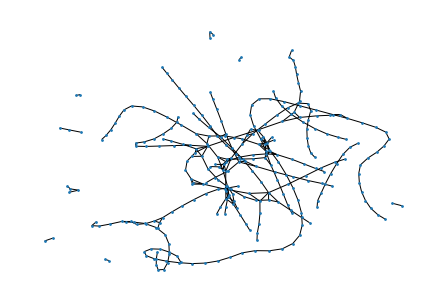

NameError: name 'DEVICE' is not defined

In [20]:
id_filename = None
adj_filename = 'PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
DE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)